# Irma ensemble forecasts analysis 

### What aspects of the INITIAL TIME differences are correlated with 
### LANDFALL TIME outcome measures (strength, track)?

Jump to [Results](#results)

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

data are on [weather server](https://weather.rsmas.miami.edu/repository/entry/show?entryid=88c07b73-cf8d-4426-9254-16c8e75c2811), click and grab OpenDAP link for your initialization time (several are there) 

In [2]:
# on weather server, i extracted two OpenDAP URLs with copy-paste
# These two are for GEFS_Global_1p0deg_Ensemble_20170904_1800.grib2 <-- this is fcst initialization time

# Full ensemble (21 members): 
URLens = 'https://weather.rsmas.miami.edu/repository/opendap/synth%3A88c07b73-cf8d-4426-9254-16c8e75c2811%3AL0dFRlNfR2xvYmFsXzFwMGRlZ19FbnNlbWJsZV8yMDE3MDkwNF8xODAwLmdyaWIy/entry.das'
ds = xr.open_dataset(URLens)
# Derived (mean and stdev and stuff)
URLder = 'https://weather.rsmas.miami.edu/repository/opendap/synth%3A88c07b73-cf8d-4426-9254-16c8e75c2811%3AL0dFRlNfR2xvYmFsXzFwMGRlZ19FbnNlbWJsZV9kZXJpdmVkXzIwMTcwOTA0XzE4MDAuZ3JpYjI%3D/entry.das'
ds_der = xr.open_dataset(URLder)

# Create outcome measures of ensemble differences at landfall time
## to correlate with *initial time* fields 

In [53]:
# Region of interest: Near Florida, landfall time

roi = ds.sel(lon=slice(360-90,360-40), lat=slice(35,15)) 
landfall = roi.sel(time2='2017-09-11 00:00:00')

# First landfall-time outcome measure: strength
### Use min SLP as strength measure

min, max:  946.84875 974.057421875  hPa


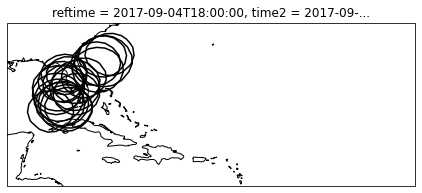

In [54]:
# Quick plot of SLP 990hPa contours, and find minimum values
SLPmins = []

# on a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[8,3])

for iens in range(21):
    SLP = landfall.Pressure_reduced_to_MSL_msl_ens[iens]
    contours = SLP.plot.contour(ax=ax,colors='k', vmin=99000,vmax=99000,levels=1)
    #print('min value: ', SLP.min().values/100.)
    SLPmins.append(SLP.min().values/100.) 

ax.coastlines();
    
print('min, max: ', min(SLPmins), max(SLPmins), ' hPa')

In [55]:
# Track the INDEX LOCATIONS of SLP minima within the ROI. 
# if you want more sophisticated tracking, https://github.com/ecjoliver/stormTracking

argmins = roi.Pressure_reduced_to_MSL_msl_ens.argmin(dim=['lat','lon'])

In [56]:
tracklons = roi.lon[argmins['lon'] ]
tracklats = roi.lat[argmins['lat']]
tracklats

<xarray.DataArray 'lat' (time2: 65, ens: 21)>
array([[17., 17., 17., ..., 17., 17., 17.],
       [17., 17., 17., ..., 17., 17., 16.],
       [17., 17., 16., ..., 17., 17., 16.],
       ...,
       [18., 26., 23., ..., 35., 18., 35.],
       [18., 28., 23., ..., 35., 18., 35.],
       [19., 29., 24., ..., 34., 18., 35.]])
Coordinates:
    lat      (time2, ens) float64 17.0 17.0 17.0 17.0 ... 18.0 34.0 18.0 35.0
    reftime  datetime64[ns] 2017-09-04T18:00:00
  * time2    (time2) datetime64[ns] 2017-09-04T18:00:00 ... 2017-09-20T18:00:00
  * ens      (ens) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Attributes:
    units:    degrees_north

Text(0.5, 1.0, 'ensemble member tracks: 18-hour rolling mean of argmin(SLP)')

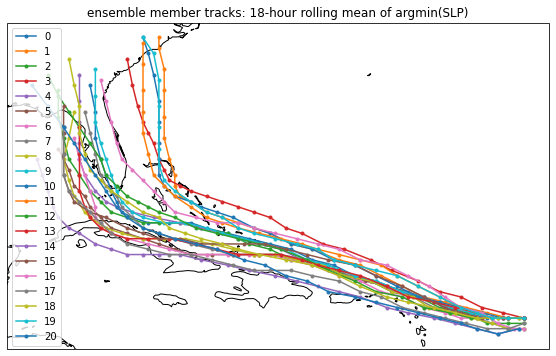

In [57]:
# tracks on a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[14,6])

for iens in range(21):
    plt.plot(tracklons.sel(ens=iens, time2=slice('2017-09-04','2017-09-12 00:00:00')).\
             rolling({"time2":3}, center=True).mean()-360., \
             tracklats.sel(ens=iens, time2=slice('2017-09-04','2017-09-12 00:00:00')).\
             rolling({"time2":3}, center=True).mean(), \
             marker='.', label=iens )

ax.coastlines();
ax.legend()
plt.title('ensemble member tracks: 18-hour rolling mean of argmin(SLP)')

# Second landfall-time outcome measure: track
### Measure it as a dipole mode in EOF(lat,lon)PC(ens) decomposition
Assuming some mode will be a dipole: second if not first... 

In [58]:
# EOFs of the landfall-time SLP field. Have to rename "ens" to "time" dimension
from eofs.xarray import Eof
solver = Eof( landfall.Pressure_reduced_to_MSL_msl_ens.rename({'ens':'time'}) )
pc = solver.pcs(npcs=1).rename({'time':'ens'})  #, pcscaling=1)
eof = solver.eofs(neofs=1)

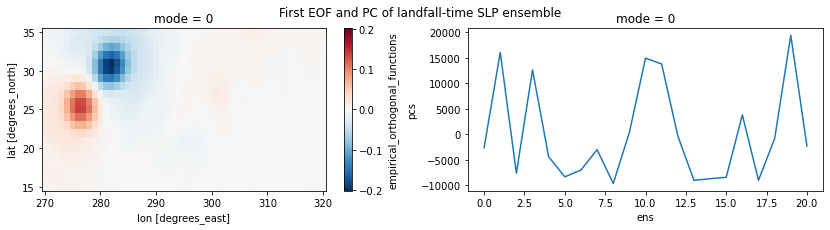

In [59]:
# Depict  it:
fig, axes = plt.subplots(ncols=2, figsize=(14,3))
fig.suptitle('First EOF and PC of landfall-time SLP ensemble')
eof.plot(ax=axes[0])
pc.plot(ax=axes[1])  #; plt.xlabel('ens. member')

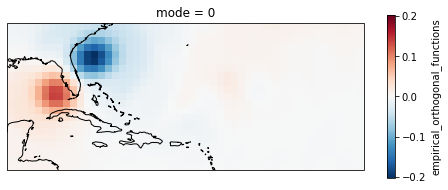

In [60]:
# Put the EOF on a proper map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[8,3])
eof.plot(ax=ax);
ax.coastlines();

In [61]:
# Correlation of SLP AT ALL TIMES IN BIG REGION with LANDFALL TIME outcome measures. 

bigroi = ds.sel(lon=slice(360-100,360-30), lat=slice(50,10)) 

# TRACK:
# use the measure of NE-SW displacement: EOF1 Mode amplitude. Rename "time" to "ens" (Eofs package demanded it)
pccor = xr.corr(pc[:,0], bigroi['Pressure_reduced_to_MSL_msl_ens'], dim="ens")

# STRENGTH: 
# use with strength measure: SLPmins. Have to make it a xarray DataArray with dimesnion called "ens" 
xSLPmins = xr.DataArray(SLPmins, dims="ens")
SLPcor =xr.corr(xSLPmins, bigroi['Pressure_reduced_to_MSL_msl_ens'], dim="ens")

<a id='results'></a>
### Result: Maps at INITIAL time, of SLP correlations with LANDFALL-time track, SLPmin

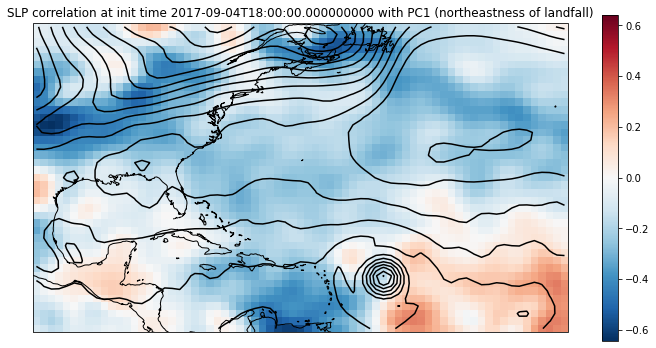

In [62]:
# Necessary for a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

# Show PCcor field
pccor[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
MSLP = ds_der.Pressure_reduced_to_MSL_msl_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10))
MSLP[0].plot.contour(colors='k',vmin=95000,vmax=102000,levels=30)
ax.coastlines();

ax.set_title('SLP correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)');

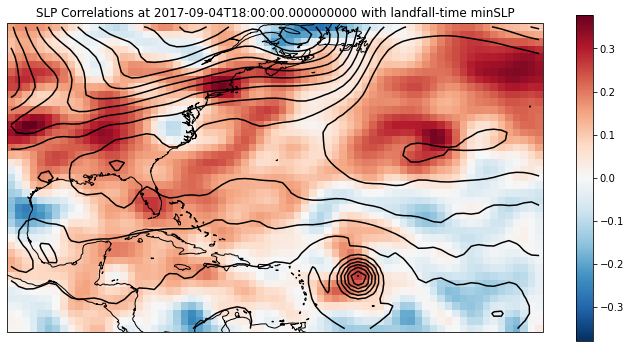

In [68]:
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

# Show SLPcor field
SLPcor[0].plot(ax=ax, cmap='RdBu_r')

# Overplot ensemble mean SLP so we can interpret correlations 
MSLP = ds_der.Pressure_reduced_to_MSL_msl_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10))
MSLP[0].plot.contour(colors='k',vmin=95000,vmax=102000,levels=30)
ax.coastlines();

ax.set_title('SLP correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)')

ax.set_title('SLP Correlations at '+str(SLPcor.time2[0].values)+' with landfall-time minSLP');

# How about Z500
## sort of a steering level for cyclones (850-200mean might be better)

In [84]:
# bigroi['v-component_of_wind_isobaric_ens'] # isobaric1 is the name of pressure levels for u,v

In [88]:
# TRACK:
# use the measure of NE-SW displacement: EOF1 Mode amplitude. Rename "time" to "ens" (Eofs package demanded it)
pccorZ = xr.corr(pc[:,0], bigroi['Geopotential_height_isobaric_ens'].sel(isobaric2=50000), dim="ens")
pccoru = xr.corr(pc[:,0], bigroi['u-component_of_wind_isobaric_ens'].sel(isobaric1=50000), dim="ens")
pccorv = xr.corr(pc[:,0], bigroi['v-component_of_wind_isobaric_ens'].sel(isobaric1=50000), dim="ens")

# STRENGTH: 
# use with strength measure: SLPmins. Have to make it a xarray DataArray with dimesnion called "ens" 
xSLPmins = xr.DataArray(SLPmins, dims="ens")
SLPcorZ =xr.corr(xSLPmins, bigroi['Geopotential_height_isobaric_ens'].sel(isobaric2=50000), dim="ens")

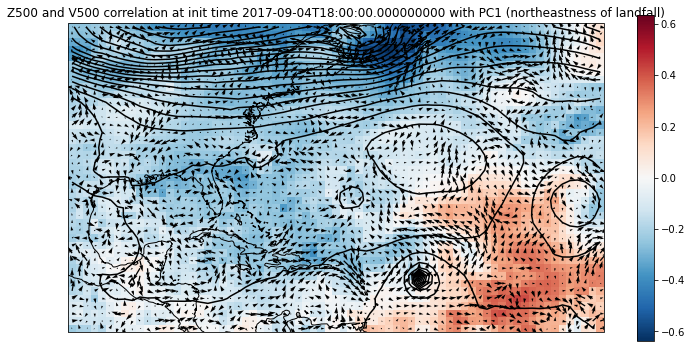

In [100]:
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

pccorZ[0].plot(ax=ax)
plt.quiver(pccoru.lon, pccoru.lat, pccoru[0],pccorv[0])

# Overplot ensemble mean Z500 so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('Z500 and V500 correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)');

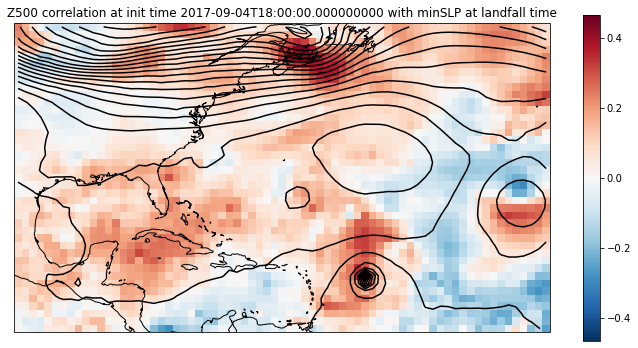

In [92]:
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

SLPcorZ[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('SLP correlation at init time '+str(pccor.time2[0].values)+\
             ' with minSLP at landfall time');

# Let's get quantitative: make the above correlation map into a REGRESSION map
## Units: (UNITS OF OUTCOME) per (UNIT OF PREDICTOR)

**regression** of minSLP on Z is this statistical model for ensemble deviations:

### $SLP_{min}' = reg(SLP_{min},Z_{500}) * Z_{500}'$

Formula is: **think units: it could be no other!**

### $reg(SLP_{min},Z_{500}) = cor(SLP_{min},Z_{500}) \times \sigma_{SLP_{min}} / \sigma_{Z_{500}}$


In [76]:
# use Pascal units for SLPmins
SLPregZ = SLPcorZ * 100*np.std(SLPmins) / ds_der.Geopotential_height_isobaric_stdDev.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)

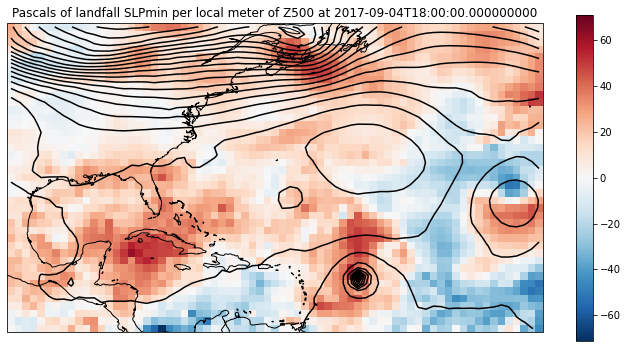

In [78]:
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

SLPregZ[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('Pascals of landfall SLPmin per local meter of Z500 at '+str(pccor.time2[0].values));

In [13]:
# quick old looks at ensemble global SLP values from this dataset
# and dataset metadata dumps 

In [19]:
# let's take the 30th time level so the values differ substantially
ds.Pressure_reduced_to_MSL_msl_ens[30]

<xarray.DataArray 'Pressure_reduced_to_MSL_msl_ens' (ens: 21, lat: 181, lon: 360)>
[1368360 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    reftime  datetime64[ns] 2017-09-04T18:00:00
    time2    datetime64[ns] 2017-09-12T06:00:00
  * ens      (ens) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Attributes:
    long_name:                      Pressure reduced to MSL @ Mean sea level
    units:                          Pa
    abbreviation:                   PRMSL
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-3-1_L101
    Grib2_Parameter:                [0 3 1]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Mass
    Grib2_Parameter_Name:           Pressure reduced to MSL
    Grib2_Level_Type:               101
    Grib2_Level_Desc:               Mean sea level
    Grib2_Generating_Process_Type:  Ensemble forecast

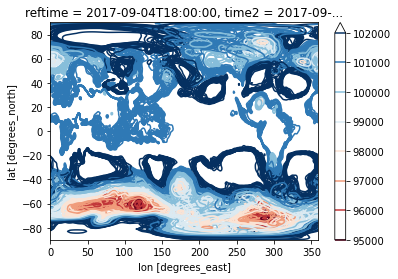

In [20]:
# spaghetti plot at lead time 20 steps (5 days)
for iens in range(21):
    contours = ds.Pressure_reduced_to_MSL_msl_ens[20][iens].plot.contour(cmap='RdBu',vmin=95000,vmax=102000,levels=8)
    
plt.colorbar(contours)

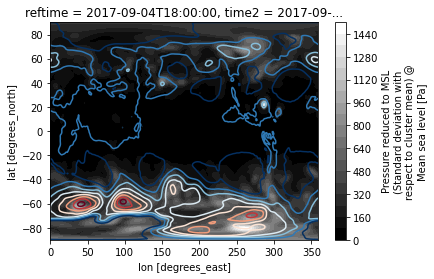

In [16]:
# Mean and standard deviation
ds_der.Pressure_reduced_to_MSL_msl_stdDev[15].plot.contourf(levels=25, cmap='gray')
ds_der.Pressure_reduced_to_MSL_msl_unweightedMean[15].plot.\
    contour(cmap='RdBu',vmin=95000,vmax=102000,levels=8)

In [17]:
ds_der = xr.open_dataset(URLder)
ds_der

<xarray.Dataset>
Dimensions:                                                                         (
                                                                                     lat: 181,
                                                                                     lon: 360,
                                                                                     time: 64,
                                                                                     time_bounds_1: 2,
                                                                                     time1: 2,
                                                                                     ...
                                                                                     height_above_ground: 1,
                                                                                     isobaric1: 12,
                                                                                     depth_below_surface_layer: 1,
                                                                                     depth_below_surface_layer_bounds_1: 2,
                                                                                     height_above_ground1: 1,
                                                                                     isobaric2: 10)
Coordinates: (12/13)
  * lat                                                                             (lat) float32 ...
  * lon                                                                             (lon) float32 ...
    reftime                                                                         datetime64[ns] ...
  * time                                                                            (time) datetime64[ns] ...
  * time1                                                                           (time1) datetime64[ns] ...
  * time2                                                                           (time2) datetime64[ns] ...
    ...                                                                              ...
  * isobaric                                                                        (isobaric) float32 ...
  * height_above_ground                                                             (height_above_ground) float32 ...
  * isobaric1                                                                       (isobaric1) float32 ...
  * depth_below_surface_layer                                                       (depth_below_surface_layer) float32 ...
  * height_above_ground1                                                            (height_above_ground1) float32 ...
  * isobaric2                                                                       (isobaric2) float32 ...
Dimensions without coordinates: time_bounds_1,
                                pressure_difference_layer_bounds_1,
                                depth_below_surface_layer_bounds_1
Data variables: (12/74)
    LatLon_Projection                                                               int32 ...
    time_bounds                                                                     (time, time_bounds_1) datetime64[ns] ...
    pressure_difference_layer_bounds                                                (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    depth_below_surface_layer_bounds                                                (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 ...
    Convective_available_potential_energy_pressure_difference_layer_stdDev          (time2, pressure_difference_layer, lat, lon) float32 ...
    Convective_available_potential_energy_pressure_difference_layer_unweightedMean  (time2, pressure_difference_layer, lat, lon) float32 ...
    ...                                                                              ...
    u-component_of_wind_isobaric_stdDev                                             (time2, isobaric1, lat, lon) float

In [18]:
ds

<xarray.Dataset>
Dimensions:                                                              (
                                                                          lat: 181,
                                                                          lon: 360,
                                                                          time: 64,
                                                                          time_bounds_1: 2,
                                                                          time1: 2,
                                                                          ...
                                                                          isobaric1: 12,
                                                                          depth_below_surface_layer: 1,
                                                                          depth_below_surface_layer_bounds_1: 2,
                                                                          height_above_ground1: 1,
                                                                          isobaric2: 10,
                                                                          ens: 21)
Coordinates: (12/14)
  * lat                                                                  (lat) float32 ...
  * lon                                                                  (lon) float32 ...
    reftime                                                              datetime64[ns] ...
  * time                                                                 (time) datetime64[ns] ...
  * time1                                                                (time1) datetime64[ns] ...
  * time2                                                                (time2) datetime64[ns] ...
    ...                                                                   ...
  * height_above_ground                                                  (height_above_ground) float32 ...
  * isobaric1                                                            (isobaric1) float32 ...
  * depth_below_surface_layer                                            (depth_below_surface_layer) float32 ...
  * height_above_ground1                                                 (height_above_ground1) float32 ...
  * isobaric2                                                            (isobaric2) float32 ...
  * ens                                                                  (ens) int32 ...
Dimensions without coordinates: time_bounds_1,
                                pressure_difference_layer_bounds_1,
                                depth_below_surface_layer_bounds_1
Data variables: (12/39)
    LatLon_Projection                                                    int32 ...
    time_bounds                                                          (time, time_bounds_1) datetime64[ns] ...
    pressure_difference_layer_bounds                                     (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    depth_below_surface_layer_bounds                                     (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 ...
    Convective_available_potential_energy_pressure_difference_layer_ens  (time2, ens, pressure_difference_layer, lat, lon) float32 ...
    Convective_inhibition_pressure_difference_layer_ens                  (time2, ens, pressure_difference_layer, lat, lon) float32 ...
    ...                                                                   ...
    Vertical_velocity_pressure_isobaric_ens                              (time2, ens, isobaric, lat, lon) float32 ...
    Water_equivalent_of_accumulated_snow_depth_surface_ens               (time2, ens, lat, lon) float32 ...
    u-component_of_wind_isobaric_ens                                     (time2, ens, isobaric1, lat, lon) float32 ...
    u-component_of_wind_height_above_ground_ens                          (time2, ens, height_above_ground1, lat, lon) float32 ...
    v-component_of